In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
OAuth 2.0 RFC6749,388.923335,35.356667,45.172697,11
pfSense,466.354186,38.862849,53.941079,12
CCH Tax Forms Project,524.365462,24.969784,42.253176,21
Accounting,537.089360,31.593492,44.076608,17
Terraform,576.465269,96.077545,126.892294,6
"The Starless Crown, Rollins",892.878264,33.069565,48.999609,27
Active Directory and Azure Files,926.497585,25.040475,40.807322,37
Python + Oauth2.0,1052.322893,45.753169,62.879808,23
FSLogix,1117.362402,93.113534,130.436894,12
Azure Functions + PP365,1149.857589,127.761954,174.969811,9


# Histogram

sum of ages: ~60289.77


<Axes: >

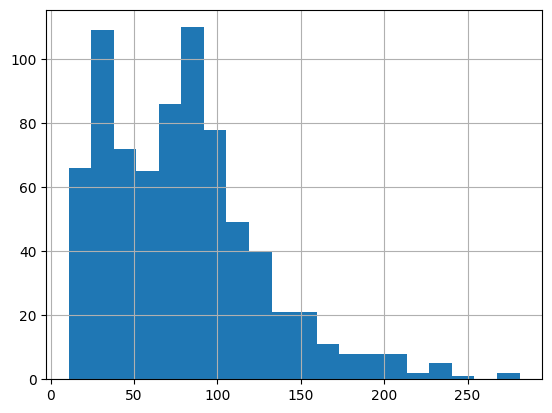

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~60289.77


<Axes: >

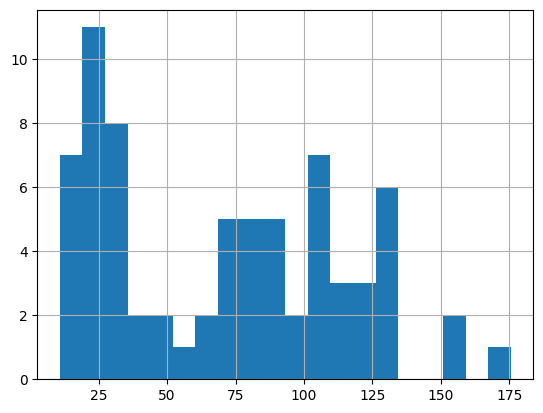

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Python']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [8]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [9]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [10]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // 5

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [11]:
n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
    existing_cards['subject_highest_age'] *= -1
existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 762
Total card age: 60289.77


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
65,Terraform,Variable References:\nRefer to variables using...,d9cdbdc6137b846a17caa27cd11b8c46,126.892294,96.077545,-126.892294,576.465269,0.453278,6,0,0,-126.892294
66,Terraform,Expressions and Operators:\nDefinition: Terraf...,3a18bd16fd51306a7e6c69ff09751d2b,126.045372,96.077545,-126.892294,576.465269,0.453278,6,1,0,-126.045372
67,Terraform,Provisioning infrastructure across multiple cl...,6142f0024e8d0327917e9f63072277cd,103.360781,96.077545,-126.892294,576.465269,0.453278,6,2,0,-103.360781
68,Terraform,Debugging Tips:\nCheck Quotes: Ensure that you...,bb1942142b9c1c162db7e0ccfdafb8d5,80.619615,96.077545,-126.892294,576.465269,0.453278,6,3,0,-80.619615
69,Terraform,Dynamic Blocks:\nDefinition: Allow you to cons...,28763e7ddcf4cb0a2802e902b77a7035,72.217354,96.077545,-126.892294,576.465269,0.453278,6,4,0,-72.217354
189,Terraform,Local Values:\nDefinition: Local values allow ...,276bce2642773e24412e2540d7ed6044,67.329853,96.077545,-126.892294,576.465269,0.453278,6,5,0,-67.329853
40,Azure Functions + PP365,Dependency Management\nThe practice of managin...,286186c4c8443bf0b572558220e97e71,174.969811,127.761954,-174.969811,1149.857589,0.316589,9,0,0,-174.969811
41,Azure Functions + PP365,Async Programming (Asyncio)\nA programming par...,84ef9036376cd6bdf68c3b08fc358303,169.363320,127.761954,-174.969811,1149.857589,0.316589,9,1,0,-169.363320
42,Azure Functions + PP365,Function Proxies\nA feature in Azure Functions...,bf413ded3c5197d25ae6a124a6fa1574,161.970234,127.761954,-174.969811,1149.857589,0.316589,9,2,0,-161.970234
43,Azure Functions + PP365,Local Debugging\nRunning and testing Azure Fun...,cef2a4ff8162c1613bdadb864f34ed66,161.647589,127.761954,-174.969811,1149.857589,0.316589,9,3,0,-161.647589



## Random

In [12]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [13]:
existing_cards.head(10)['age'].sum()

np.float64(1244.41622292519)

In [14]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
0,PnP PowerShell,Remove-PnPFile (PnP.PowerShell)\nDeletes a spe...,82aa6d1579ce68a7efaf6bae61eb3a03,281.180286,122.618607,-281.180286,4659.507074,0.380192,38,0,0,-281.180286
1,PnP PowerShell,Invoke-RestMethod Parameters\nKey parameters i...,e6a04d0a76f2a4a9cba720d23ffea2c8,272.079268,122.618607,-281.180286,4659.507074,0.380192,38,1,0,-272.079268
5,TSQL,Q: What is the purpose of the GROUP BY clause ...,48a62cc5d988221ac8669ebbd8b27594,246.126317,122.781502,-246.126317,2946.756040,0.543850,24,0,0,-246.126317
10,JavaScript Concepts,When ... appears on the right-hand side of an ...,10bddd23b38f376d792526c3e14f9065,240.021442,84.503011,-240.021442,5323.689666,0.614978,63,0,0,-240.021442
3,PnP PowerShell,Environment Variables\nVariables that are set ...,e888c7c4c00e3b122457c3d900fd4e77,232.751930,122.618607,-281.180286,4659.507074,0.380192,38,2,0,-232.751930
2,PnP PowerShell,Invoke-WebRequest (Microsoft.PowerShell.Utilit...,6b09af70ff47a16ac9835232449e7bf9,232.461463,122.618607,-281.180286,4659.507074,0.380192,38,3,0,-232.461463
15,Azure VM + Developer,X11 Forwarding\nAn SSH technique that lets GUI...,0541a216239d45b4dd18aaea19bd5712,228.338077,117.921977,-228.338077,3655.581284,0.146689,31,0,0,-228.338077
6,TSQL,Self-Joins for Hierarchies:\n\nUseful for comp...,ead33c6a0051c6b6229a06a68ac14f06,228.138813,122.781502,-246.126317,2946.756040,0.543850,24,1,0,-228.138813
20,C# Basics,Indexers allow objects to be indexed like arra...,8b8cd7dfc49d7351086701c7627b6136,224.614313,120.632214,-224.614313,2533.276496,0.612699,21,0,0,-224.614313
25,VMWare,Storage vMotion\n\nThe ability to migrate virt...,2e3e71c9de5d2efac881521e2e5b348d,215.962590,112.123184,-215.962590,2466.710042,0.581431,22,0,0,-215.962590


In [15]:
existing_cards['age'].mean()

np.float64(79.12043457900624)